In [12]:
################### #
# Attach packages ----
################### #
library(tidyverse)
library(tidymodels)
library(xgboost)
library(readxl)
library(writexl)
library(randomForest)

In the random forest method mtry is the number of covariates to choose from at each split. These are
chosen at random at each internal node where a split is investigated. For regression we typically choose
$m = p/3 = 17/3 ≈ 6$. This is the only tuning parameter in random forest. We can find the best mtry using
OOB error and test error.

In [13]:
#################### #
# Read data and mutate: ----
# Include lat, long and municipalities in data set 
# - Keep only the 220 most common municipalities in the datase
#################### #

houses_raw <- read_excel("temp/houses.xlsx")

houses <- houses_raw %>%
  select(id, sqm, expense, tot_price, lat, lng, kommune_name) %>%
  mutate(kommune_factor = fct_lump_n(kommune_name, 220) %>% as.integer())

In [14]:
################## #
# Split data using the rsample package ----
# Set seed in order to make the analysis reproducible 
################### #
set.seed(42)

split <- initial_split(houses, prop = 3/4)
train_raw <- training(split)
test_raw  <- testing(split)

train <- train_raw %>%
  select(-kommune_name, -id)

test <- test_raw %>%
  select(-kommune_name, -id)

In [4]:
head(train,2)

sqm,expense,tot_price,lat,lng,kommune_factor
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
152,0,9800000,59.95475,10.76841,141
189,0,8400000,59.98290,11.01450,170


In [5]:
houses_number_predictors = 5

In [6]:

mse.test = double(houses_number_predictors)
oob.mse = double(houses_number_predictors)

for (i in 1:houses_number_predictors){
    rf=randomForest(tot_price~.,data=train, mtry=i, ntree=1000)
    oob.mse[i] = rf$mse[1000]
    rf_pred = predict(rf, test)
    mse.test[i] = mean((rf_pred-test$tot_price)^2)
}

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




In [8]:
pdf("m_selection_rf_plot.pdf") 

matplot(1:houses_number_predictors, cbind(oob.mse,mse.test),pch=19,col=c("gray","black"),type='b',ylab="MSE",xlab="Number of splits")
points(which.min(mse.test),mse.test[which.min(mse.test)],pch=19,col="red")
points(which.min(oob.mse),oob.mse[which.min(oob.mse)],pch=19,col="red")
legend("topright",legend=c("OOB","Test"),pch=19,col=c("gray","black"))

dev.off()

pdf 
  2

From plot above we see that test MSE and OOB error is smallest for __mtry__=2. We choose the model with fewest variables, __mtry__=2, in order to decrease the chance of overfitting.

In [15]:
rf=randomForest(tot_price~.,
                data=train,
                mtry=2,ntree=1000,importance=TRUE)
yhat.rf=predict(rf,newdata=test)


In [8]:
rf_MSE=mean((yhat.rf-test$tot_price)^2)
rf_MSE

[1] 1.749551e+12

In [13]:
################### #
# View summary of the prediction ----
# Use the package yardstick to get evaluation of the model
################### #

model_preds <- 
  predict(rf, test) %>% 
  bind_cols(test_raw) %>% 
  rename(estimate     = '...1', 
         truth        = tot_price) %>%
  mutate(abs_dev      = abs(truth - estimate),
         abs_dev_perc = abs_dev/truth) 
head(model_preds,2)

New names:
* NA -> ...1



estimate,id,sqm,expense,truth,lat,lng,kommune_name,kommune_factor,abs_dev,abs_dev_perc
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>
3857429,10002,66,5147,3275086,59.94381,10.81159,Oslo,141,582342.52,0.17780984
2990462,10007,33,3559,3035761,59.94471,10.77751,Oslo,141,45298.77,0.01492172


In [14]:
mape(model_preds, truth, estimate)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mape,standard,24.9516


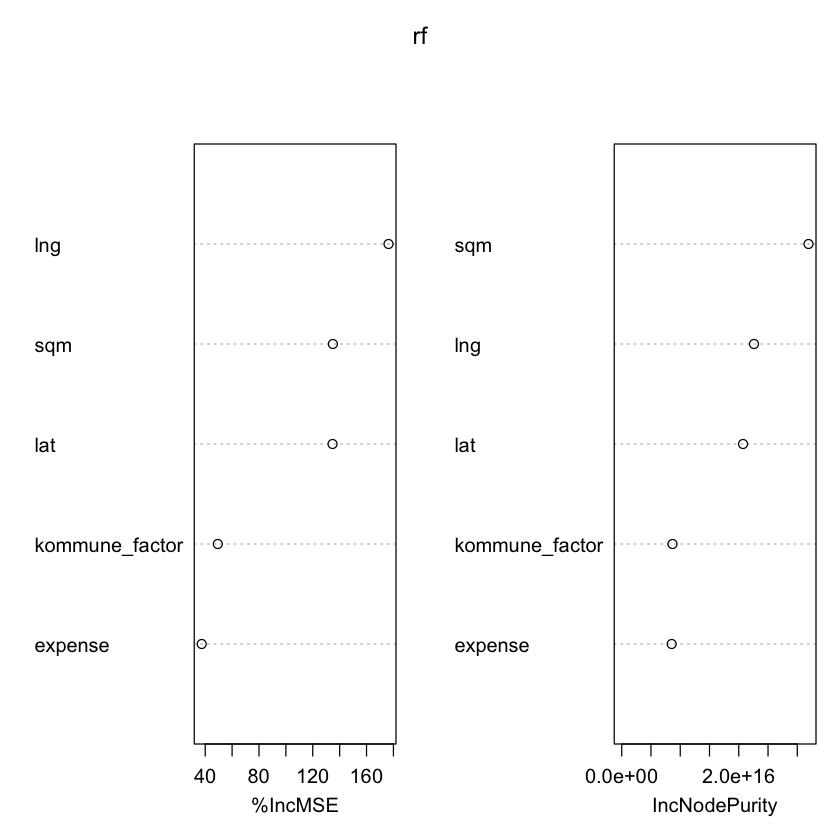

In [31]:
################### #
# Show importance plot of the model ----
# Using the package xgboost
################### #

varImpPlot(rf) 

In [17]:
pdf("preds_rf_plot.pdf") 


##################################### #
# Plot predictions ----
##################################### #
# Truth vs estimation
model_preds %>% 
  ggplot(aes(x = estimate/1000000, y = truth/1000000)) +
  geom_point(color = "dodgerblue3", alpha = 0.4) +
  labs(x = "Predicted price [MNOK]",
       y = "Actual price [MNOK]") +
  theme_minimal()

dev.off()

pdf 
  2

In [19]:
pdf("hist_rf_plot.pdf") 
#Histogram of percentage error
model_preds %>%
  ggplot(aes(abs_dev_perc)) + 
  geom_histogram(fill = "dodgerblue3", color = "white", bins=50) +
  labs(title = "Histogram for percentage error",
       x     = "Percentage error",
       y     = "Count") +
  scale_x_continuous(limits = c(0,5), labels = scales::percent) +
  theme_minimal()

dev.off()

Warning message:
“Removed 9 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


pdf 
  2

In [22]:
pdf("dev_rf_plot.pdf") 
#Plot of abs_dev_perc by sqm (filter by total value > 5 million) 
model_preds %>%
  filter(truth > 5000000) %>%
  ggplot(aes(x = sqm, y = abs_dev_perc)) +
  geom_point(color = "dodgerblue3", alpha = 0.4) +
  labs(title = "Percentage error vs square meters",
       x     = "Square meters",
       y     = "Percentage error") +
  scale_y_continuous(limits = c(0, 10), labels = scales::percent) +
  xlim(0, 500) +
  theme_minimal()
dev.off()

Warning message:
“Removed 8 rows containing missing values (geom_point).”


pdf 
  2

In [23]:
pdf("dev_by_city_rf_plot.pdf")
# Plot of abs_dev_perc by sqm (for Troms? and Bod?)
model_preds %>%
  filter(kommune_name == "Oslo" | kommune_name == "Bergen") %>%
  ggplot(aes(x = sqm, y = abs_dev_perc, color = as.factor(kommune_name))) +
  geom_point() +
  labs(title = "Percentage error vs square meters",
       x     = "Square meters",
       y     = "Percentage error") +
  scale_y_continuous(labels = scales::percent) + 
  xlim(0, 500) +
  theme_minimal()
dev.off()

Warning message:
“Removed 2 rows containing missing values (geom_point).”


pdf 
  2

In [36]:
################### #
# Write prediction data to excel ----
################### #

write_xlsx(model_preds, "temp/rf_predictions.xlsx")

In [16]:
library("shapper")
library("DALEX")
train = data.frame(train)

Welcome to DALEX (version: 2.2.0).
Find examples and detailed introduction at: http://ema.drwhy.ai/



Attaching package: ‘DALEX’


The following objects are masked from ‘package:shapr’:

    explain, update_data


The following object is masked from ‘package:dplyr’:

    explain




In [17]:
exp_rf <- explain(rf, data = train[,-3], y = train[,3])

Preparation of a new explainer is initiated
  -> model label       :  randomForest  (  default  )
  -> data              :  15156  rows  5  cols 
  -> target variable   :  15156  values 
  -> predict function  :  yhat.randomForest  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package randomForest , ver. 4.6.14 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  275758.9 , mean =  3612734 , max =  50878039  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -4910722 , mean =  -7281.257 , max =  19121961  
  A new explainer has been created!  


In [ ]:
ive_rf <- shap(exp_rf, new_observation = train[1,-3])

In [2]:
!conda install -c conda-forge shap

ERROR: Error in parse(text = x, srcfile = src): <text>:1:8: unexpected symbol
1: !conda install
           ^


In [10]:
train = data.frame(train)
as.numeric(train[,3])

[1]  9800000  8400000  7250000  2310000  6400000  3300000  4003707  3188201
    [9]  4969239  5649735  2961756  3997000  5700000  3939000  9750543  2177254
   [17]  3604502  5116452  2958980 13990000  2717127  2350000  2306000  3607932
   [25]  3178000  5193332  4805000  2500000  4606098  3200000 10800000  6350000
   [33]  3218158  4890000  4950000  2800000  5000000  5295128  6709000  2983000
   [41] 17900000  3700000  2674000  3487500  3713484  4376144  3400000  9300000
   [49]  4150000  3690000  3110248  6990000 11000000  3390000  4200000  4390000
   [57]  3951000  2960000  3350000  3850000  3850000  6482433  2350000  3390000
   [65]  3390000  3297952  4590000  2134074  1890000  3532981  3300000  3595374
   [73]  3690231  2730000  3371250  2921690  6200000  3441000  3566000  3760000
   [81]  3312439  2248790  5380000  8750000  5450000  6175000  2290000  4990000
   [89]  2791780  6722796  9500000  8286000  2890000  2466360  1990000  7400000
   [97]  3550000  3430000  4030474  6877676  3590000  8500000  5301683  6500000
  [105] 12500000  3350527  3534559  3450000  3700000 10035049  5314563  3300000
  [113]  2484920  4950000  4100000  2600000  3990000  2990000  8900000  7800000
  [121]  2400000  8850000  4400000  3487303  3150000  8660700  3990000  6000000
  [129]  1990000  5950000  3495654  2927781  2990000  3971379  2650000  3408219
  [137]  3966000 10800000  2384000  2625941  5800000  2105218  7256532  4490000
  [145]  5900000  3750000 11360000  5000000  3550000  2771000  5780321  6500000
  [153]  7690000  6250000  7590000  7590000  4490000  4100000  4490000  2751159
  [161]  6500000  3000000  6150000  4267305  2678000  2290000  7300000  4390000
  [169]  2600000  5150000  4300000  3450000  3950000  1800000  3153043  3386000
  [177]  4390000  3300000  5994006  2700000  4490000  2100000  4632441  4990000
  [185]  2150000  3240000  7290000  2987435  2590000  4450000  4090000  4405805
  [193]  8500000  3390000  5475345  7906000  5494389  2750000  7090000  2623641
  [201]  2307530  4600000  7890000  4000000  3490000  3290000  1980000  4150000
  [209]  2164237  3150000  2990000  5890000  5254287  3519318  3016000  3877352
  [217]  3250000  2316515 10500000  2900000  3122000  3151639  3450000  2250000
  [225]  2335755  5750000  4430559  3990000  3411067  2190000  1960130  4824116
  [233]  3994136  1824917  5526000  4336000  3090000  2130990  2888013  4750000
  [241] 21000000  3348658  4000000  2910000  2950000  3490000  2350000 12551606
  [249]  3093741  3350000  2255173  2744000  6500000  4836283  6200000  3000000
  [257]  2290000  1850000  3125000  2820000  4990000 11531343  2395000  4190000
  [265]  3077887  4600000  2826626  6208934  2949478  2685362  3690000  6490000
  [273]  1842522  8400000  4490000 15500000  4595695 11970712  3600000  4200000
  [281]  2978000  5500000  4500000  4190000  3690000  2430000  3275000  3890000
  [289]  1372471  4495044  2634309   446000  2400000  2600000  2390000  3990000
  [297]  8775000  3985000  1438832  6201768  3250000 12600000  2983405  2239367
  [305]  3790000  4450000  2550000  3111000  3159000   846112  2681070  7990000
  [313]  3092000  5150000  2246835  2663885  1985465  2437130  1680000  5690000
  [321]  3750000  5990000  5690000 12900000  3300000  7990000  4990000  3490000
  [329]  3990000  2857000  1400000  4004248  4490000  3250000  3890000  1590000
  [337]  5290000  3950000  3890000  3150000  2250000  9412306  2100000  1992375
  [345]  2150000  3132000  2300000  2954932  7799000  1890000  4497659  2300000
  [353]  9500000  4290000  2890000  4150000  2529000  3543950  7990000  7950000
  [361]  4990000  2690821  2300880  4490000  1707206  5924482 15000000  8400000
  [369]  1988589  5600000  7900000  1890000  2850000  3650000  3867000  1920000
  [377]  1190000  4190000  4428000  3798992  1990000 19000000  3190000  3119012
  [385]  2190000  2890000  3000821  3277000 12500000  8390000  5500000  2024619
  [393]  3550000  3514803  1850000  2993414  2450000  3790000  4200000  1967000
  [4

In [7]:
library("DALEX")
library("titanic")

Welcome to DALEX (version: 2.2.0).
Find examples and detailed introduction at: http://ema.drwhy.ai/



Attaching package: ‘DALEX’


The following object is masked from ‘package:dplyr’:

    explain




In [8]:
titanic_train <- titanic[,c("survived", "class", "gender", "age", "sibsp", "parch", "fare", "embarked")]
titanic_train$survived <- factor(titanic_train$survived)
titanic_train$gender <- factor(titanic_train$gender)
titanic_train$embarked <- factor(titanic_train$embarked)
titanic_train <- na.omit(titanic_train)
head(titanic_train)

,survived,class,gender,age,sibsp,parch,fare,embarked
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,no,3rd,male,42,0,0,7.11,Southampton
2,no,3rd,male,13,0,2,20.05,Southampton
3,no,3rd,male,16,1,1,20.05,Southampton
4,yes,3rd,female,39,1,1,20.05,Southampton
5,yes,3rd,female,16,0,0,7.13,Southampton
6,yes,3rd,male,25,0,0,7.13,Southampton


In [15]:
titanic_train

,survived,class,gender,age,sibsp,parch,fare,embarked
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,no,3rd,male,42.0000000,0,0,7.1100,Southampton
2,no,3rd,male,13.0000000,0,2,20.0500,Southampton
3,no,3rd,male,16.0000000,1,1,20.0500,Southampton
4,yes,3rd,female,39.0000000,1,1,20.0500,Southampton
5,yes,3rd,female,16.0000000,0,0,7.1300,Southampton
6,yes,3rd,male,25.0000000,0,0,7.1300,Southampton
7,no,2nd,male,30.0000000,1,0,24.0000,Cherbourg
8,yes,2nd,female,28.0000000,1,0,24.0000,Cherbourg
9,yes,3rd,male,27.0000000,0,0,18.1509,Cherbourg


In [4]:
install.packages('shapr')

also installing the dependencies ‘condMVNorm’, ‘mvnfast’





The downloaded binary packages are in
	/var/folders/4v/sdg24jrj2xs5wpxdks_9f1cr0000gn/T//RtmpLiqOLg/downloaded_packages


In [8]:
library(shapr)


Attaching package: ‘shapr’


The following object is masked from ‘package:parsnip’:

    prepare_data


The following object is masked from ‘package:dplyr’:

    explain




In [9]:
x_train <- as.matrix(train[,-3])
y_train <- as.matrix(train[,3])
x_test <- as.matrix(test[,-3])

In [11]:
explainer <- shapr(train[,-3], rf)
p <- mean(y_train)
explanation <- explain(
  x_test,
  approach = "empirical",
  explainer = explainer,
  prediction_zero = p
)


ERROR: Error in get_model_specs(model): You passed a model to shapr which is not natively supported See ?shapr::shapr or the vignette
for more information on how to run shapr with custom models.


In [ ]:
plot(explanation, plot_phi0 = FALSE, index_x_test = c(1, 2))